In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from numpy.polynomial import Polynomial as P
from PIL import Image
%matplotlib inline

PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

BASE_IMG = None
CANNY_IMG = None

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

In [3]:
#print('This image is:', type(image), 'with dimesions:', image.shape)
#image = Image.open(image).convert("L")
#plt.imshow(image, cmap='gray')  

In [4]:
import math

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def filter_color(img):
    yellow_min = np.array([65, 80, 80], np.uint8)
    yellow_max = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 80, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    global PREV_LEFT_X1, PREV_LEFT_X2, PREV_RIGHT_X1, PREV_RIGHT_X2
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    #print(lines[0][0])
    for line in lines:
        line = line[0]
        s = slope(line)

        if 0.3 > s > -0.3:
            continue

        if s < 0:
            if line[0] > img.shape[1] / 2 + 40:
                continue

            left_x += [line[0], line[2]]
            left_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [0, 0, 255], thickness)
        else:
            if line[0] < img.shape[1] / 2 - 40:
                continue

            right_x += [line[0], line[2]]
            right_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [255, 255, 0], thickness)

    y1 = img.shape[0]
    y2 = img.shape[0] / 2 + 90

    if len(left_x) <= 1 or len(right_x) <= 1:
        if PREV_LEFT_X1 is not None:
            cv2.line(img, (int(PREV_LEFT_X1), int(y1)), (int(PREV_LEFT_X2), int(y2)), color, thickness)
            cv2.line(img, (int(PREV_LEFT_X2), int(y1)), (int(PREV_RIGHT_X2), int(y2)), color, thickness)
        return

    left_poly = P.fit(np.array(left_x), np.array(left_y), 1)
    right_poly = P.fit(np.array(right_x), np.array(right_y), 1)

    left_x1 = (left_poly - y1).roots()
    right_x1 = (right_poly - y1).roots()

    left_x2 = (left_poly - y2).roots()
    right_x2 = (right_poly - y2).roots()

    if PREV_LEFT_X1 is not None:
        left_x1 = PREV_LEFT_X1 * 0.7 + left_x1 * 0.3
        left_x2 = PREV_LEFT_X2 * 0.7 + left_x2 * 0.3
        right_x1 = PREV_RIGHT_X1 * 0.7 + right_x1 * 0.3
        right_x2 = PREV_RIGHT_X2 * 0.7 + right_x2 * 0.3

    PREV_LEFT_X1 = left_x1
    PREV_LEFT_X2 = left_x2
    PREV_RIGHT_X1 = right_x1
    PREV_RIGHT_X2 = right_x2

    cv2.line(img, (int(left_x1), int(y1)), (int(left_x2), int(y2)), color, thickness)
    cv2.line(img, (int(right_x1), int(y1)), (int(right_x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [6]:
Image_list=os.listdir("test_images/")
hsv_images=[]
t="test_images/"

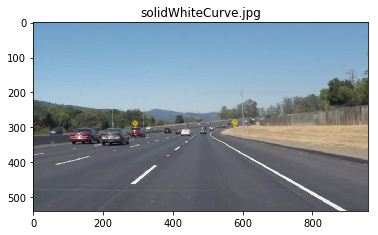

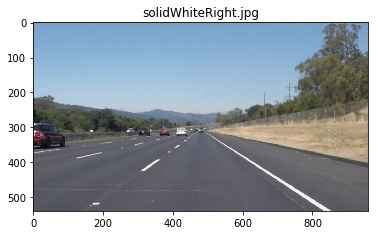

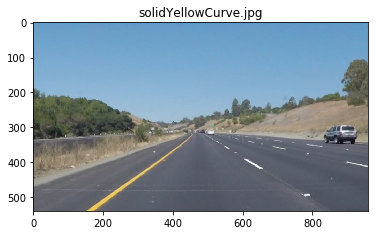

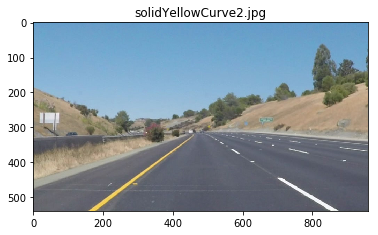

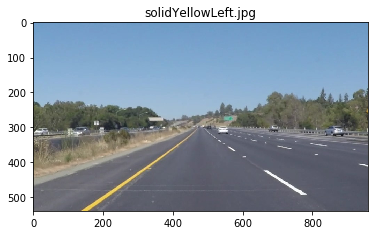

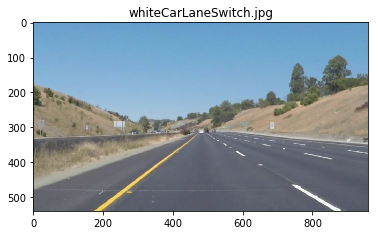

In [7]:
for im in Image_list:
    ims=mpimg.imread(t+im)
    plt.title(im)
    plt.imshow(ims)
    plt.figure()
    i_h=to_hsv(ims)
    hsv_images.append(i_h)

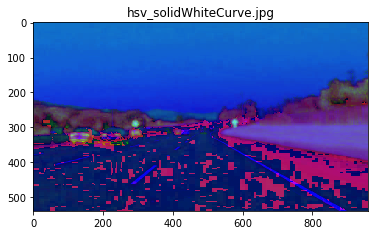

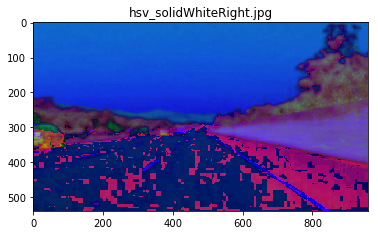

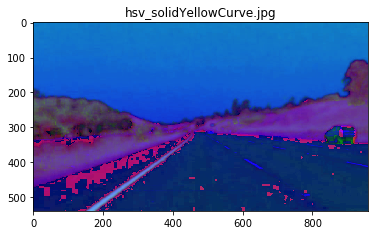

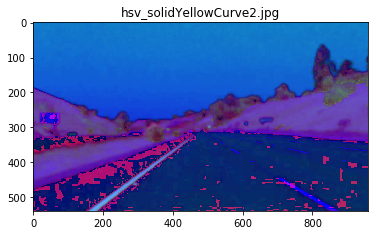

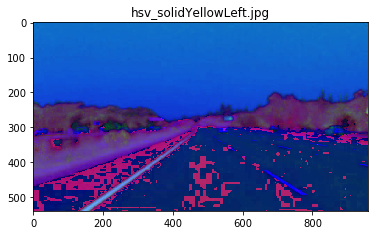

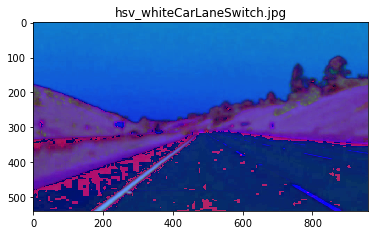

In [8]:
#print(len(hsv_images))
for i in range(len(Image_list)):
    plt.imshow(hsv_images[i],cmap='gray');
    plt.title('hsv_'+Image_list[i])
    plt.figure()

In [9]:
gs_images=[] # gaussian blur image list
for i in range(len(Image_list)):
    im=Image_list[i]
    ims=mpimg.imread(t+im)
    gs=grayscale(ims)
    gs_images.append(gs)

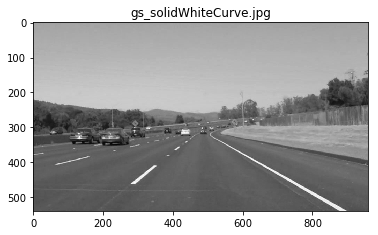

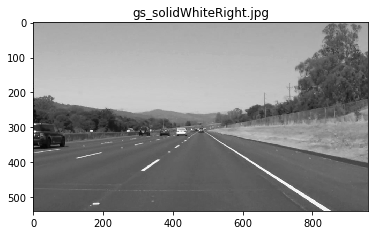

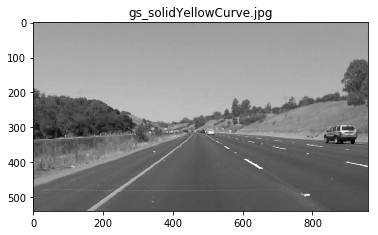

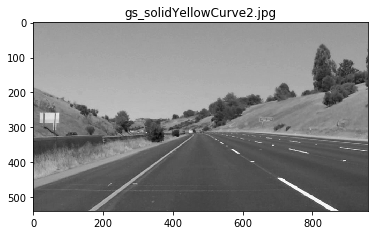

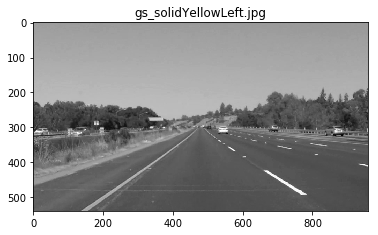

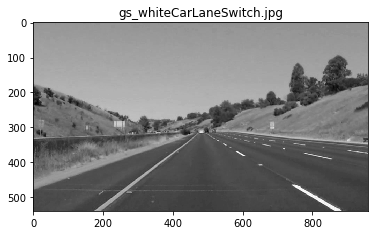

In [10]:
for i in range(len(Image_list)):
    plt.imshow(gs_images[i],cmap='gray')
    plt.title('gs_'+Image_list[i])
    plt.figure()

canny_images=[] 
for i in range(len(Image_list)):
    canny_1=canny(gs_images[i],93,183)
    canny_images.append(canny_1)

In [11]:
gb_images=[] 
for i in range(len(Image_list)): 
    gb=gaussian_blur(gs_images[i],7) 
    gb_images.append(gb)

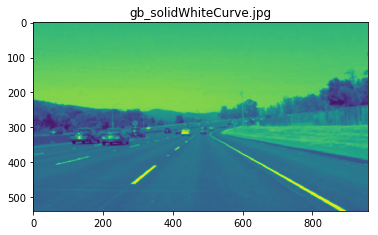

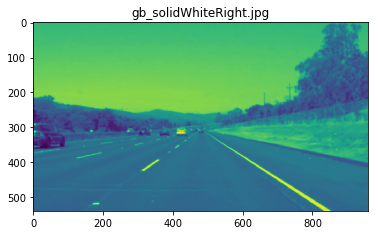

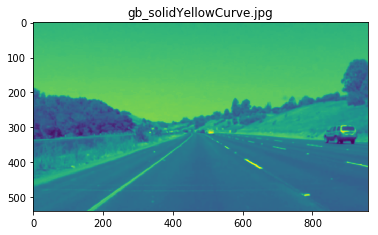

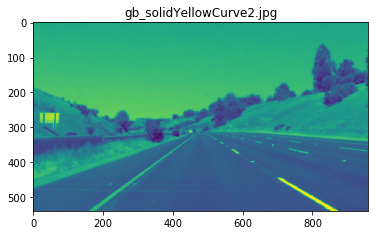

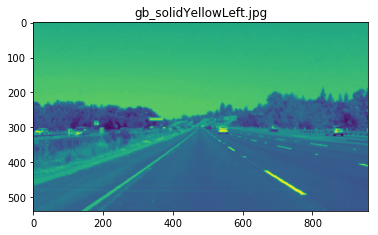

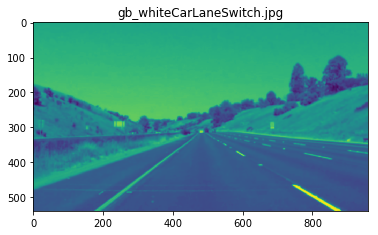

In [12]:
for i in range(len(Image_list)):
    plt.imshow(gb_images[i])
    plt.title('gb_'+Image_list[i])
    plt.figure()

In [13]:
canny_images=[] 
for i in range(len(Image_list)): 
    canny_1=canny(gb_images[i],50,125) 
    canny_images.append(canny_1)


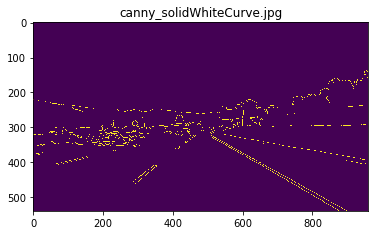

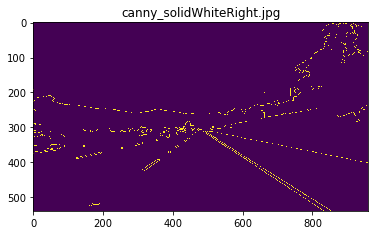

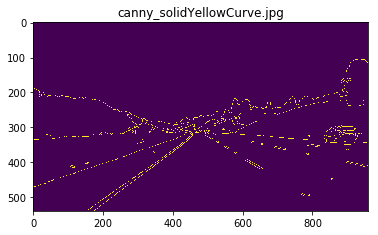

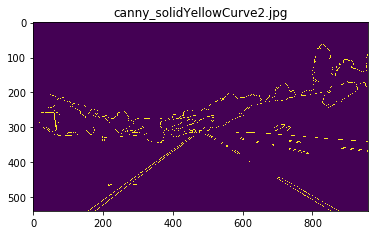

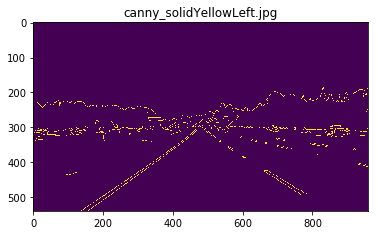

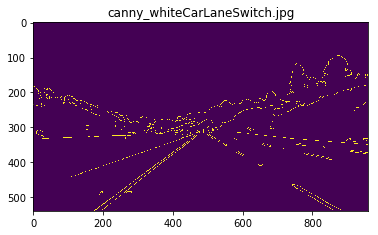

In [14]:
for i in range(len(Image_list)):
    plt.imshow(canny_images[i])
    plt.title('canny_'+Image_list[i])
    plt.figure()

In [15]:
bot_left=[80,540]
bot_right=[980,540]
apex_right=[510,315]
apex_left=[450,315]
roi_images=[] 
v=[np.array([bot_left,bot_right,apex_right,apex_left],dtype=np.int32)]
for i in range(len(Image_list)):
    roi=region_of_interest(canny_images[i],v); 
    roi_images.append(roi)

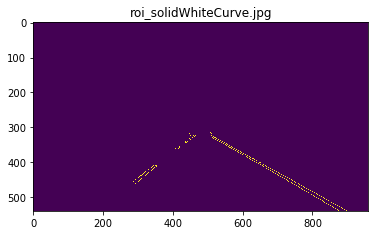

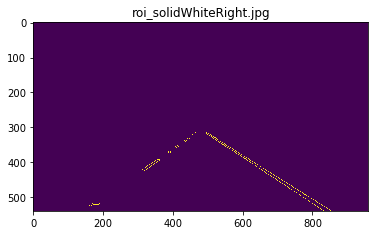

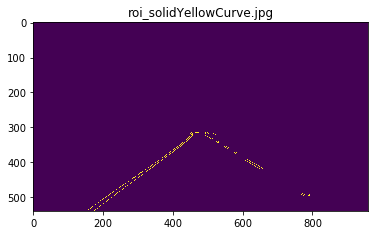

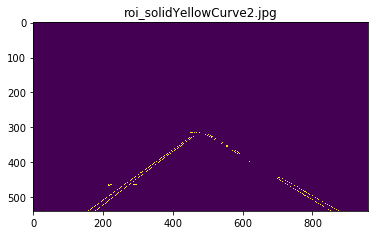

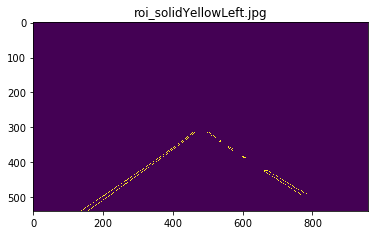

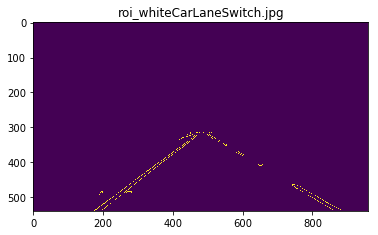

In [16]:
for i in range(len(Image_list)):
    plt.imshow(roi_images[i])
    plt.title('roi_'+Image_list[i])
    plt.figure()

In [17]:
hough_images=[]
for i in range(len(Image_list)):
    hough_line=hough_lines(roi_images[i], 0.8, np.pi/180, 25, 50, 200)
    hough_images.append(hough_line)

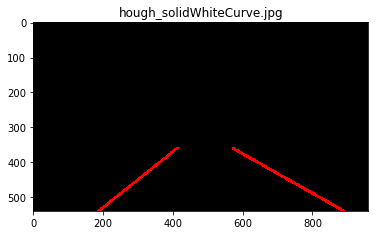

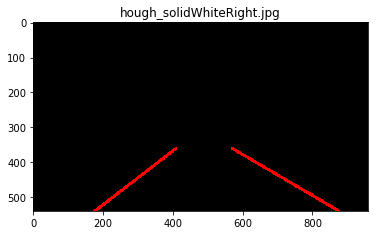

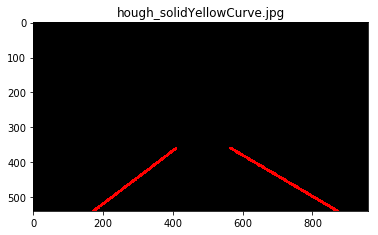

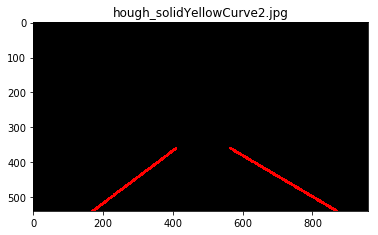

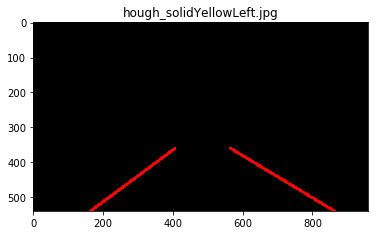

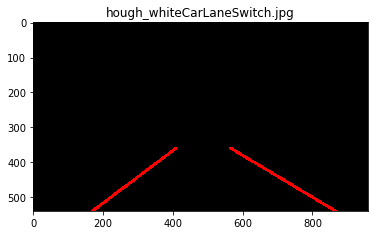

In [18]:
for i in range(len(Image_list)):
    plt.imshow(hough_images[i])
    plt.title('hough_'+Image_list[i])
    plt.figure()

In [19]:
weighted_images=[]
for i in range(len(Image_list)):
    original_image=mpimg.imread(t+Image_list[i])
    weighted_image=weighted_img(hough_images[i],original_image )
    weighted_images.append(weighted_image)

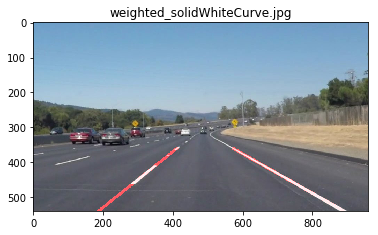

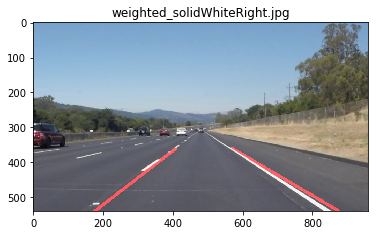

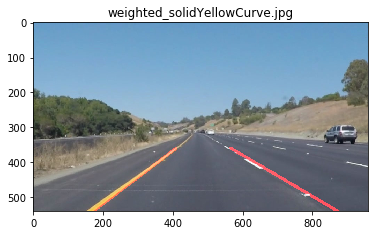

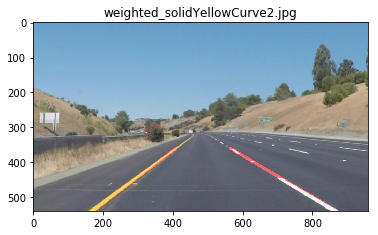

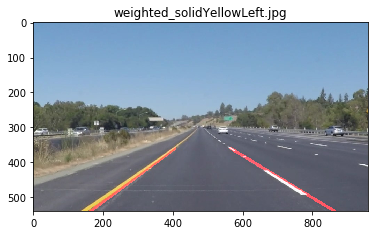

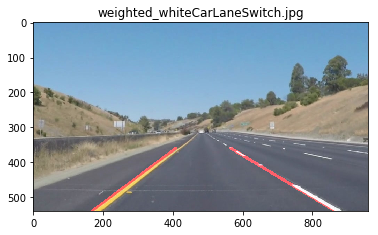

In [20]:
for i in range(len(Image_list)):
    plt.imshow(weighted_images[i])
    plt.title('weighted_'+Image_list[i])
    plt.figure()

In [21]:
from moviepy.editor import VideoFileClip

In [22]:
from IPython.display import HTML

In [23]:
def process_image(base_img):
    global BASE_IMG, CANNY_IMG
    BASE_IMG = base_img
    ysize = base_img.shape[0]
    xsize = base_img.shape[1]
    image = to_hsv(base_img)
    image = gaussian_blur(image, 3)
    image = filter_color(image)
    image = canny(image, 30, 130)
    CANNY_IMG = image
    image = region_of_interest(
        image,
        np.array(
            [[(40, ysize), (xsize / 2, ysize / 2 + 40), (xsize / 2, ysize / 2 + 40), (xsize - 40, ysize)]],
            dtype=np.int32
        )
    )
    image = hough_lines(image, 1, np.pi / 90, 10, 15, 10)

    # return image
    return weighted_img(image, base_img, β=250.)

In [26]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 29.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.44 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [29]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:24<00:00, 28.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 25 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [32]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 43%|██████████████████████████████████                                              | 107/251 [00:07<00:11, 12.71it/s]WARNING:py.warnings:C:\Users\pranay\Anaconda2\envs\yourNewenvironment1\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: divide by zero encountered in double_scalars

100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 20.5 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))